## Course: DSC530
## Assignment: 11.2, Survival Analysis
## Name: Laura Hoffmann
## Date: 11/15/2020
### Setup

In [1]:
import numpy as np
import pandas as pd
import thinkstats2
import thinkplot

import warnings
warnings.filterwarnings('ignore')

import survival
resp6 = survival.ReadFemResp2002()
resp7 = survival.ReadFemResp2010()

# 13-1

In NSFG Cycles 6 and 7, the variable cmdivorcx contains the date of divorce for the respondent’s first marriage, if applicable, encoded in century-months.

Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage.

Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.

Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

In [2]:
def CleanData(resp):
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    resp['notdivorced'] = resp.cmdivorcx.isnull().astype(int)
    resp['duration'] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp['durationsofar'] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pd.to_datetime('1899-12-15')
    dates = [month0 + pd.DateOffset(months=cm) 
             for cm in resp.cmbirth]
    resp['decade'] = (pd.DatetimeIndex(dates).year - 1900) // 10
    
CleanData(resp6)
married6 = resp6[resp6.evrmarry==1]

CleanData(resp7)
married7 = resp7[resp7.evrmarry==1]

In [3]:
from collections import Counter

def EstimateHazardFunction(complete, ongoing, label='', verbose=False):
    if np.sum(np.isnan(complete)):
        raise ValueError("complete contains NaNs")
    if np.sum(np.isnan(ongoing)):
        raise ValueError("ongoing contains NaNs")

    hist_complete = Counter(complete)
    hist_ongoing = Counter(ongoing)

    ts = list(hist_complete | hist_ongoing)
    ts.sort()

    at_risk = len(complete) + len(ongoing)

    lams = pd.Series(index=ts)
    for t in ts:
        ended = hist_complete[t]
        censored = hist_ongoing[t]

        lams[t] = ended / at_risk
        if verbose:
            print(t, at_risk, ended, censored, lams[t])
        at_risk -= ended + censored

    return survival.HazardFunction(lams, label=label)

In [4]:
complete6 = resp6[resp6.notdivorced == 0].duration.dropna()
ongoing6 = resp6[resp6.notdivorced == 1].durationsofar.dropna()

complete7 = resp7[resp7.notdivorced == 0].duration.dropna()
ongoing7 = resp7[resp7.notdivorced == 1].durationsofar.dropna()

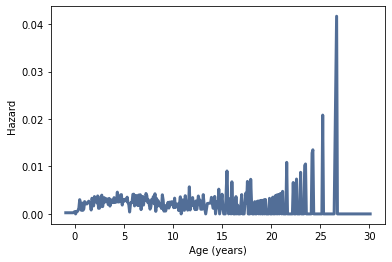

In [5]:
# Hazard Function for cycle 6

hf = EstimateHazardFunction(complete6, ongoing6)
thinkplot.Plot(hf)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Hazard')

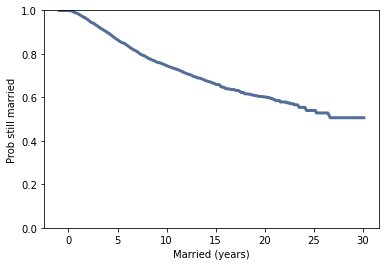

In [6]:
# Survival Function for cycle 6

hf = EstimateHazardFunction(complete6, ongoing6)
sf = hf.MakeSurvival()
thinkplot.Plot(sf)
thinkplot.Config(xlabel='Married (years)',
                 ylabel='Prob still married',
                 ylim=[0, 1])

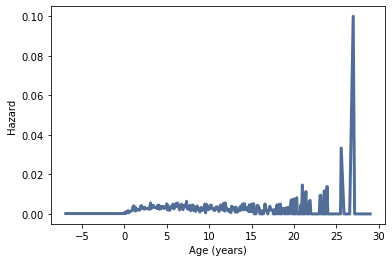

In [7]:
# Hazard Function for cycle 7

hf = EstimateHazardFunction(complete7, ongoing7)
thinkplot.Plot(hf)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Hazard')

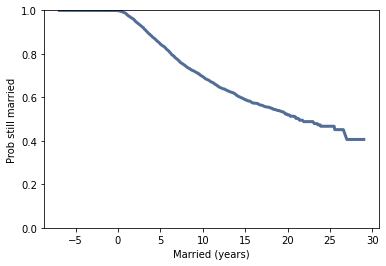

In [8]:
# Survival Function for cycle 7

hf = EstimateHazardFunction(complete7, ongoing7)
sf = hf.MakeSurvival()
thinkplot.Plot(sf)
thinkplot.Config(xlabel='Married (years)',
                 ylabel='Prob still married',
                 ylim=[0, 1])

In [9]:
# Plot data from several resamples to visualize sampling error

def EstimateMarriageDuration(married):
    complete = married[married.notdivorced==0].duration.dropna()
    ongoing = married[married.notdivorced==1].durationsofar.dropna()

    hf = EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

def ResampleDuration(resp, iters=101):
    _, sf = EstimateMarriageDuration(resp)
    thinkplot.Plot(sf)

    low, high = resp.duration.min(), resp.duration.max()
    ts = np.arange(low, high, 1/12.0)

    ss_seq = []
    for _ in range(iters):
        sample = thinkstats2.ResampleRowsWeighted(resp)
        _, sf = EstimateMarriageDuration(sample)
        ss_seq.append(sf.Probs(ts))

    low, high = thinkstats2.PercentileRows(ss_seq, [5, 95])
    thinkplot.FillBetween(ts, low, high, color='gray', label='90% CI')

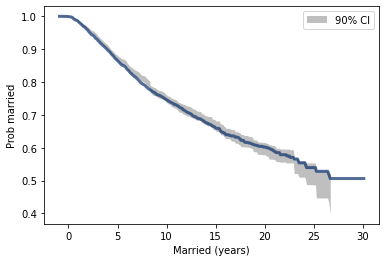

In [10]:
# Cycle 6

ResampleDuration(resp6)
thinkplot.Config(xlabel='Married (years)',
                 ylabel='Prob married',
                 loc='upper right')

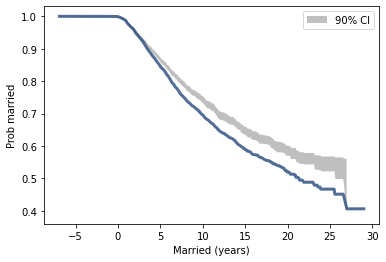

In [11]:
# Cycle 7

ResampleDuration(resp7)
thinkplot.Config(xlabel='Married (years)',
                 ylabel='Prob married',
                 loc='upper right')

In [12]:
# Dividing the respondents into groups by decade of birth

def ResampleDivorceCurve(resps):
    for _ in range(11):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        PlotDivorceCurveByDecade(sample, color='red', alpha=0.1)
    thinkplot.Show(xlabel='years',
                   axis=[0, 28, 0, 1])
    
def ResampleDivorceCurveByDecade(resps):
    for i in range(41):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby('decade')
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)
        EstimateSurvivalByDecade(groups, alpha=0.1)
    thinkplot.Config(xlabel='Years',
                     ylabel='Fraction undivorced',
                     axis=[0, 28, 0, 1])
    
def EstimateSurvivalByDecade(groups, **options):
    thinkplot.PrePlot(len(groups))
    for name, group in groups:
        _, sf = EstimateSurvival(group)
        thinkplot.Plot(sf, **options)
        
def EstimateSurvival(resp):
    complete = resp[resp.notdivorced == 0].duration.dropna()
    ongoing = resp[resp.notdivorced == 1].durationsofar.dropna()
    hf = survival.EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

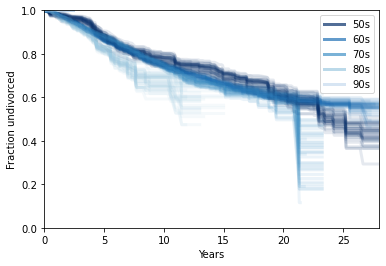

In [13]:
ResampleDivorceCurveByDecade([married6, married7])